## Detection of correlated input to FS with and without gap junctions.

Here we run one population unit, and steadily increase the input frequency to see roughly what level of activity we should use for the experiment.

In [1]:
import os
import numpy as np

os.environ["SNUDDA_DATA"] = "../../../../BasalGangliaData/data/"
assert os.path.isdir(os.getenv("SNUDDA_DATA")), f"You need to have BasalGangliaData installed for this example."

network_path = os.path.join("networks", "FS-input-correlation-detection-2")
rc = None

In [2]:
from snudda import SnuddaInit
si = SnuddaInit(network_path=network_path, random_seed=12345)
# 50 -> 10 to speed it up
si.define_striatum(num_dSPN=0, num_iSPN=0, num_FS=10, num_LTS=0, num_ChIN=0)



Using cube for striatum
Neurons for striatum read from /home/hjorth/HBP/BasalGangliaData/data/neurons/striatum
Adding neurons: FS from dir /home/hjorth/HBP/BasalGangliaData/data/neurons/striatum/fs


In [3]:
from snudda import SnuddaPlace
sp = SnuddaPlace(network_path=network_path)
sp.place()

### Plotting the network
Plotting the network to verify that the population units are placed the way we expect.

Population unit 1 has 50 neurons


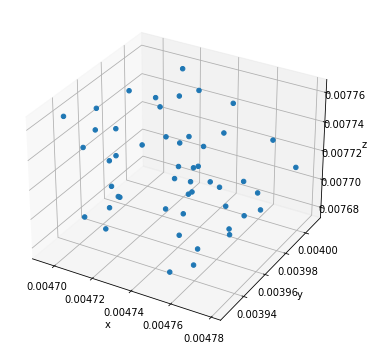

In [4]:
from snudda.plotting import PlotNetwork
pos_file = os.path.join(network_path, "network-neuron-positions.hdf5")

pn = PlotNetwork(pos_file)
pn.plot_populations()

# The commented code below also plots the network, but with the option to plot more detail of the neurons:
# pn = PlotNetwork(network_path)
# pn.plot(plot_axon=False, plot_dendrite=False, plot_synapses=False, colour_population_unit=True)

pn.close()  # Close the hdf5 file so others can use it (or better shut down kernel after)

### Check if ipyparallel running
For larger networks it is useful to run network creation in parallel.

In [5]:
import os
from ipyparallel import Client

os.environ["IPYTHONDIR"] = ".ipython"
os.environ["IPYTHON_PROFILE"] = "default"

u_file = os.path.join(".ipython", "profile_default", "security", "ipcontroller-client.json")
if os.path.exists(u_file):
    rc = Client(url_file=u_file, timeout=120, debug=False)
else:
    print("Warning, running in serial.")
    rc = None

Warning, running in serial.


In [6]:
from snudda import SnuddaDetect

sd = SnuddaDetect(network_path=network_path, rc=rc, verbose=False)
sd.detect()

No d_view specified, running distribute neurons in serial
Processing hyper voxel : 115/336 (50 neurons)
Processing hyper voxel : 163/336 (50 neurons)
Processing hyper voxel : 171/336 (48 neurons)
Processing hyper voxel : 116/336 (46 neurons)
Processing hyper voxel : 123/336 (45 neurons)
Processing hyper voxel : 164/336 (44 neurons)
Processing hyper voxel : 124/336 (36 neurons)
Processing hyper voxel : 155/336 (34 neurons)
Processing hyper voxel : 162/336 (34 neurons)
Processing hyper voxel : 107/336 (33 neurons)
Processing hyper voxel : 172/336 (30 neurons)
Processing hyper voxel : 114/336 (26 neurons)
Processing hyper voxel : 156/336 (25 neurons)
Processing hyper voxel : 108/336 (24 neurons)
Processing hyper voxel : 122/336 (19 neurons)
Processing hyper voxel : 170/336 (18 neurons)
Processing hyper voxel : 67/336 (17 neurons)
Processing hyper voxel : 211/336 (16 neurons)
Processing hyper voxel : 212/336 (15 neurons)
Processing hyper voxel : 154/336 (14 neurons)
Processing hyper voxel 

In [7]:
from snudda import SnuddaPrune

sp = SnuddaPrune(network_path=network_path, rc=rc, verbose=False)
sp.prune()

Read 42825 out of total 42825 synapses
Read 5680 out of total 5680 gapJunctions


### Generate input

Next we generate the input according to specifications in [FS-input-correlation-detection-2.json](FS-input-correlation-detection-2.json)

In [8]:
from snudda.input import SnuddaInput
si = SnuddaInput(network_path=network_path, 
                 input_config_file=os.path.join("FS-input-correlation-detection-2.json"),
                 time=20,
                 rc=rc, verbose=False)
si.generate()

Loading 50 neurons with 4995 synapses and 3443 gap junctions
Writing spikes to networks/FS-input-correlation-detection-2/input-spikes.hdf5


### Plot the input to verify it looks reasonable

In [9]:
from snudda.plotting import PlotInput
input_file = os.path.join(network_path, "input-spikes.hdf5")
spi = PlotInput(input_file)

Loading 50 neurons with 4995 synapses and 3443 gap junctions


Input to FS population unit 1. We successively increase the input frequency for cortical signal every 2 seconds. The second half of each period has correlation between the units with the population unit, the first does not (correlation is then only within the neuron).

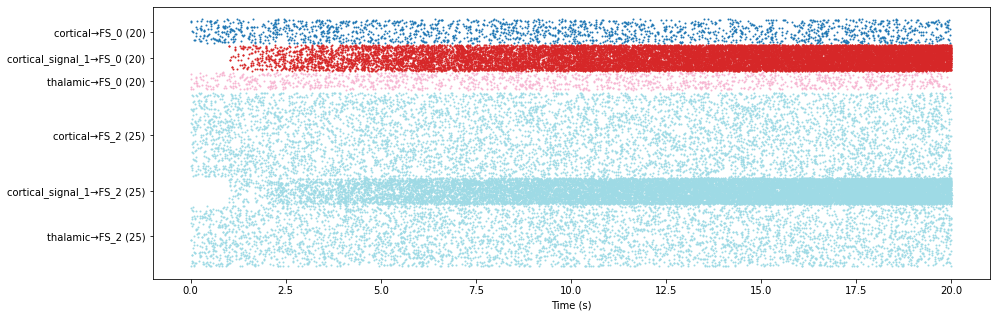

In [10]:
spi.plot_input_population_unit(population_unit_id=1, num_neurons=2, neuron_type="FS", fig_size=(15,5))

### Compile neuron modules

In [11]:
!nrnivmodl ../../../../BasalGangliaData/data/neurons/mechanisms

/home/hjorth/HBP/Snudda/examples/notebooks/FS-network
Mod files: "../../../../BasalGangliaData/data/neurons/mechanisms/bk_ch.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/bk_fs.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/bk_ms.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/ca_ch.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/cadyn_fs.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/cadyn_ms.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/cal12_ms.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/cal13_ms.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/cal_ch.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/caldyn_ms.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/can_fs.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/can_ms.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/cap_ch.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/caq_fs.mod" "../

### Run the simulation

In [12]:
!mpiexec -n 6 snudda simulate networks/FS-input-correlation-detection-2 --time 20

numprocs=6
Using input file networks/FS-input-correlation-detection-2/input-spikes.hdf5
Using input file networks/FS-input-correlation-detection-2/input-spikes.hdf5
NEURON mechanisms already compiled, make sure you have the correct version of NEURON modules.
If you delete x86_64 directory (or nrnmech.dll) then you will force a recompilation of the modules.
NEURON mechanisms already compiled, make sure you have the correct version of NEURON modules.
If you delete x86_64 directory (or nrnmech.dll) then you will force a recompilation of the modules.
Using input file networks/FS-input-correlation-detection-2/input-spikes.hdf5
Using input file networks/FS-input-correlation-detection-2/input-spikes.hdf5
args: Namespace(action='simulate', path='networks/FS-input-correlation-detection-2', network_file=None, input_file=None, output_file=None, time=20.0, record_volt=True, randomseed=None, neuromodulation=None, disable_synapses=False, disable_gj=False, mech_dir=None, profile=False, verbose=False,

Worker 3/6 writing data to networks/FS-input-correlation-detection-2/simulation/output.hdf5
Worker 4/6 writing data to networks/FS-input-correlation-detection-2/simulation/output.hdf5
Worker 5/6 writing data to networks/FS-input-correlation-detection-2/simulation/output.hdf5
Worker 6/6 writing data to networks/FS-input-correlation-detection-2/simulation/output.hdf5
Program run time: 1664.3s


In [13]:
!mpiexec -n 6 snudda simulate networks/FS-input-correlation-detection-2 --time 20 --disableGJ --outputFile networks/FS-input-correlation-detection-2/simulation/output-no-GJ.hdf5

numprocs=6
Using input file networks/FS-input-correlation-detection-2/input-spikes.hdf5
NEURON mechanisms already compiled, make sure you have the correct version of NEURON modules.
If you delete x86_64 directory (or nrnmech.dll) then you will force a recompilation of the modules.
args: Namespace(action='simulate', path='networks/FS-input-correlation-detection-2', network_file=None, input_file=None, output_file='networks/FS-input-correlation-detection-2/simulation/output-no-GJ.hdf5', time=20.0, record_volt=True, randomseed=None, neuromodulation=None, disable_synapses=False, disable_gj=True, mech_dir=None, profile=False, verbose=False, exportCoreNeuron=False, record_all=None)
!!! WE HAVE DISABLED GAP JUNCTIONS !!!
Using input file networks/FS-input-correlation-detection-2/input-spikes.hdf5
NEURON mechanisms already compiled, make sure you have the correct version of NEURON modules.
If you delete x86_64 directory (or nrnmech.dll) then you will force a recompilation of the modules.
args: 

CHeck why not able to save...
Using sample dt = None (sample step size None)
Worker 1/6 writing data to networks/FS-input-correlation-detection-2/simulation/output-no-GJ.hdf5
Worker 2/6 writing data to networks/FS-input-correlation-detection-2/simulation/output-no-GJ.hdf5
Worker 3/6 writing data to networks/FS-input-correlation-detection-2/simulation/output-no-GJ.hdf5
Worker 4/6 writing data to networks/FS-input-correlation-detection-2/simulation/output-no-GJ.hdf5
Worker 5/6 writing data to networks/FS-input-correlation-detection-2/simulation/output-no-GJ.hdf5
Worker 6/6 writing data to networks/FS-input-correlation-detection-2/simulation/output-no-GJ.hdf5
Program run time: 1448.4s


Loading networks/FS-input-correlation-detection-2/simulation/output.hdf5


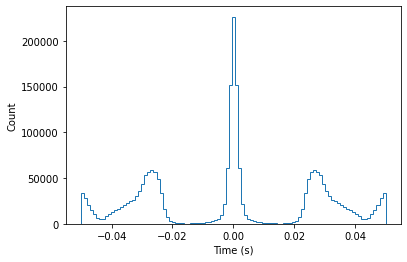

<Figure size 432x288 with 0 Axes>

In [14]:
from snudda.plotting.plot_cross_correlogram import PlotCrossCorrelogram
pcc1 = PlotCrossCorrelogram(os.path.join(network_path, "simulation", "output.hdf5"))
pcc1.plot_all_pair_cross_correlogram(neuron_id=None, fig_file_name=os.path.join(network_path, "figures", "FS-cross-corr.png"))

Loading networks/FS-input-correlation-detection-2/simulation/output-no-GJ.hdf5


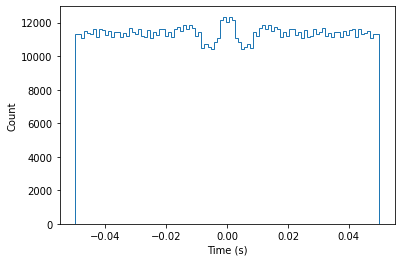

<Figure size 432x288 with 0 Axes>

In [15]:
pcc2 = PlotCrossCorrelogram(os.path.join(network_path, "simulation", "output-no-GJ.hdf5"))
pcc2.plot_all_pair_cross_correlogram(neuron_id=None, fig_file_name=os.path.join(network_path, "figures", "FS-cross-corr-no-gj.png"))

### Plotting

We want to see what frequency we should have the cortical input at to get gap junction case to spike.

Loading 50 neurons with 4995 synapses and 3443 gap junctions
Loading networks/FS-input-correlation-detection-2/simulation/output.hdf5
Saving figure to networks/FS-input-correlation-detection-2/figures/spike-raster-gj.pdf


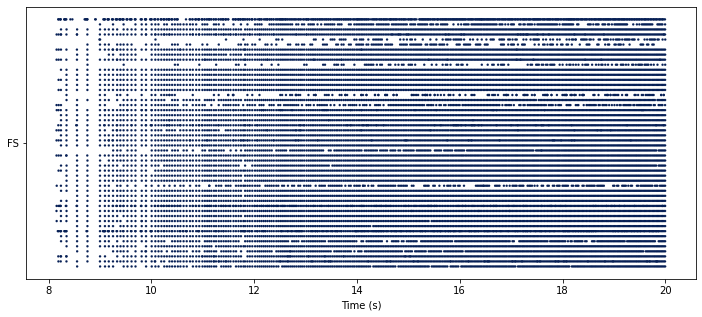

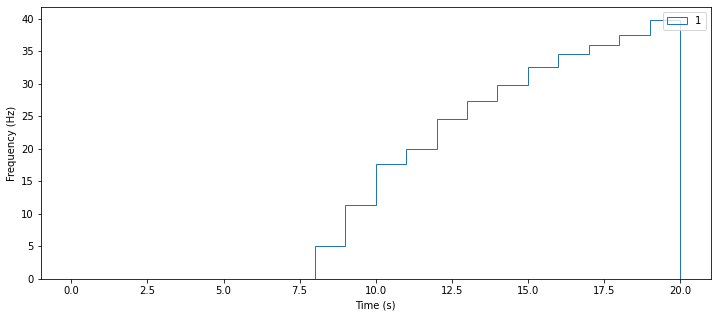

In [22]:
from snudda.plotting import SnuddaPlotSpikeRaster2
sim_file = os.path.join(network_path, "simulation", "output.hdf5")
spr = SnuddaPlotSpikeRaster2(network_path=network_path, simulation_file=sim_file)
spr.plot_spike_raster(fig_file="spike-raster-gj.pdf", fig_size=(12,5))
spr.plot_spike_histogram(bin_size=1000e-3, fig_file="spike-histogram-gj.pdf", fig_size=(12,5))

Loading 50 neurons with 4995 synapses and 3443 gap junctions
Loading networks/FS-input-correlation-detection-2/simulation/output-no-GJ.hdf5
Saving figure to networks/FS-input-correlation-detection-2/figures/spike-raster-no-gj.pdf


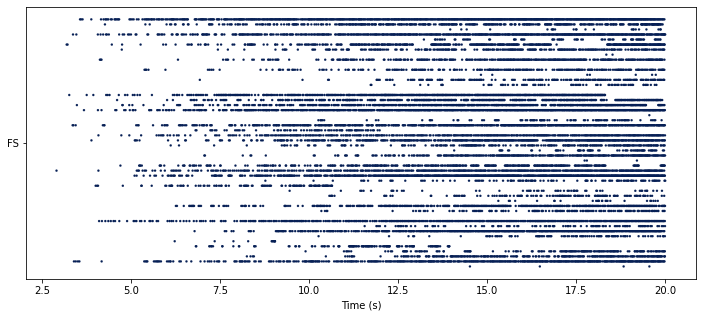

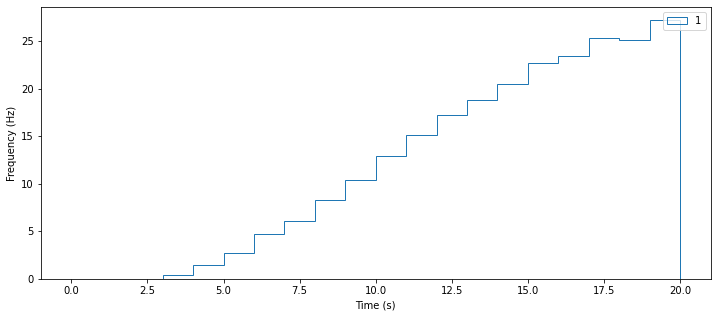

In [21]:
from snudda.plotting import SnuddaPlotSpikeRaster2
sim_file_no_gj = os.path.join(network_path, "simulation", "output-no-GJ.hdf5")

spr2 = SnuddaPlotSpikeRaster2(network_path=network_path, simulation_file=sim_file_no_gj)
spr2.plot_spike_raster(fig_file="spike-raster-no-gj.pdf", fig_size=(12,5))
spr2.plot_spike_histogram(bin_size=1000e-3, fig_file="spike-histogram-no-gj.pdf", fig_size=(12,5))